# Project 2 Final Deliverable

By Jonathan Montague and Caroline Rausch

#### Question: How cold can it be outside for me to comfortably sleep in my sleeping bag?

For the purposes of this model, we are defining a comfortable sleeping temperature to be around room temperature which is roughly 18 to 20 degrees celcius. 

# Initialization of Jupyter

In [411]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# Body Heat Data

We used data from the article "Heat loss from a human body", which relates the temperature of the environment to the heat flow from the human body.

Here we convert the data into a table from a graph.

In [412]:
# heat loss from graph converted into K from C
heat_loss = [155, 128, 107, 92, 74, 60, 40];

# surrounding temperature at which data was collected
surrounding_temp = [278, 283, 288, 293, 298, 303, 308];

# creates a DataFrame table with the heat loss and the temperature at which that heat loss is observed
HeatTable = Series(data=heat_loss, index=surrounding_temp);

Here we define a function to return an approximation of heat loss for any surrounding temperature.
We then create a python function to return the heat flow out of your body for any temperature. 

In [413]:
I = interpolate(HeatTable);

In [414]:
def get_body_heat(Itemp):
    return I(Itemp)

# Experiment

We wanted to collect real life data on how our sleeping bag heats up. 

For our experiment, we took our sleeping bag outside and first allowed it to cool to outside temperature. Then, we used a thermister to record the voltage across the thermister which directly corresponds to the internal temperature of the sleeping bag. We had a test subject lay inside the sleeping bag and recorded the change in temperature over time. We had the test subject wear minimal clothing to reduce the effects of the insulating abilities of the clothes. The top of the bag was closed during the experiment to limit the transfer of internal and external air. No sleeping pad was used during the experiment, the sleeping bag was placed directly on the grass. 

The sleeping bag we used was rated as a 20 degree F (-7 degrees celcius) sleeping bag. We approximated the mass of the air inside the sleeping bag while our test subject was inside to be between .2 and .4 kg. 

Here we import the experimental data into a table. We adjust the time index so that the graph will better line up with our model. We then plot the voltage across the thermister vs. time. 

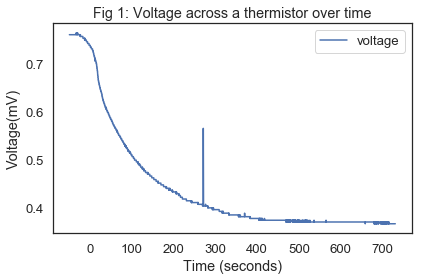

In [415]:
from pandas import read_csv
filename = 'ModSimTemp.csv'
tables = read_csv(filename, header=0, index_col=0)
len(tables)
tables.columns = ['voltage']
tables.index +=550

tables.plot()

decorate(xlabel='Time (seconds)',
         ylabel='Voltage(mV)',
         title='Fig 1: Voltage across a thermistor over time')

Figure 1 shows the voltage across the thermister over time during our experiment. Time = 0 corresponds to the time at which the test subject got inside the sleeping bag. 
The abnormality in the data at 280 seconds is due to movement from the test subject and does not impair the experiment or have any significance. 

Here we convert the voltage across the thermister into internal temperature of the sleeping bag. 

In [416]:
voltage = tables.voltage
resistance = 10000*voltage/(5-voltage)
temperature = 1 / ((1 / 298) + ((np.log(resistance / 1000)) / 3528))
tables.voltage = temperature
tables.columns = ['data']

Here we define a function to plot the data. 

In [418]:
def plot_data(tables):
    tables.data=tables.data-273
    tables.plot()
    decorate(xlabel='Time (seconds)',
             ylabel='Internal Temperature (degrees C)',
             title='Fig 2: Internal temperature over time')
    tables.data=tables.data+273

Here we plot the data. 

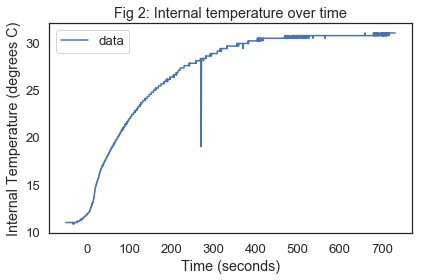

In [419]:
plot_data(tables)

In Figure 2 the internal temperature of the sleeping bag, which was calculated from our data, is plotted over time. The experimental error at 280 seconds transfers from the voltage data. This error is insignificant towards our experiment. The internal temperature of the sleeping bag starts at around 12 degrees celcius and levels off at around 30 degrees celcius. 

# Modeling Sleeping Bag Temperature

Otemp is the outside temperature. We assign otemp to be 285K (12 degrees C) to match the outside temperature from when our data was collected. 

In [420]:
Otemp = 285;

The Rvalue represents the thermal resistivity of our sleeping bag. We adjusted this value to allow our model to better fit our data. This value is helpful when comparing sleeping bags because more thermally resistant, and warmer, sleeping bags will have higher Rvalues. 

t0 is the start time.

t_end is the end time of our simulation in seconds. 

In [421]:
Rvalue = .75
t0=0
t_end=800;

Here we define our init and system objects. The init internal temperature and outside temperature are set to be equal because we allow our sleeping bag to cool to the outside temperature before running our experiment. 

In the system, the air mass is set to .35 kg because this allowed our model to best fit our data while remaining within our approximated range of the air mass inside the sleeping bag. 

The air specific heat is a property of air and is always 1005 J/(kg*K).

We set our time step (dt) equal to 1 second. 

In [422]:
init = State(Itemp = Otemp)
system = System(Otemp=Otemp , Rvalue=Rvalue, Air_mass=.35, Air_specific_heat=1005, t0=t0, t_end=t_end, dt=1)

,values
Otemp,285.00
Rvalue,0.75
Air_mass,0.35
Air_specific_heat,1005.00
t0,0.00
t_end,800.00
dt,1.00


Here is our update function.

dHdt is the rate of change of thermal energy of the air inside the sleeping bag. It is determined by two factors. The first is the heat flow from the test subject's body into the air inside the sleeping bag, and the second factor is the heat flow from the air inside the sleeping bag to outside the sleeping bag. 

The heat from the test subject's body to the air is found using our get_body_heat function based on the internal temperature (Itemp). This value is divided by 2.3 to account for the loss of about half of the heat directly into the ground from laying on the sleeping bag, as well as some heat escaping out of the sleeping bag top. 

The heat flow from the internal air to the external environment is found using Fourier's law. The law is: heat flow = (T-Tenv)/R. We used Euler's Method to approximate the actual total amount of thermal energy. This method assumes that the only heat transfer is from the test subject to the internal sleeping bag air, and from the air inside the sleeping bag to the external environment. We believe this is a fair assumption because these are the major sources of heat transfer.

We multiply this by dt to account for our time step. 

We then calculate the new internal temperature using the equation Q=mcΔT. 

In [423]:
def update_func(state, t, system):
   
    Itemp = state
    unpack(system)
    
    dHdt = (((get_body_heat(Itemp))/2.3 - (Itemp - Otemp)/Rvalue))*dt
    
    Itemp += dHdt/(Air_mass*Air_specific_heat)
    
    return Itemp

# Run Simulation

Here we define our run simulation. The results of our simulation are stored in a time frame. 

In [424]:
def run_simulation(system, update_func):
    
    init = State(Itemp = Otemp)
    system.Otemp = Otemp
    
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    frame.Itemp=frame.Itemp-273
    
    return frame

We define a function to plot our results and our data. 

In [425]:
def plot_results_data(results, tables):
    
    tables.data=tables.data-273
   
    ax = results.plot()
    tables.plot(ax=ax)
    
    tables.data=tables.data+273
    
    decorate(xlabel='Time (seconds)',
             ylabel='Internal Temperature (degrees C)',
             title='Fig 3: Internal temperature over time')

We then run the simulation and plot the results.

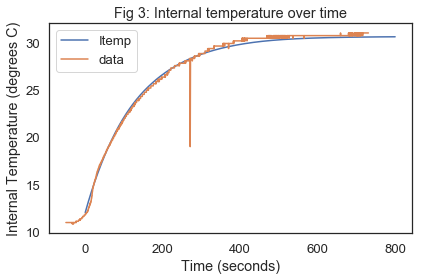

In [427]:
results = run_simulation(system,update_func)
plot_results_data(results, tables)

As the graph shows, the curve of our data and our results overlap very closely. 

# Results

To answer our question, we needed to find the minimum outside temperature at which our sleeping bag still warmed up to a comfortable temperature. 

In order to find this minimum temperature, we input five different outsides temperatures into our model and recorded the results. 

In [432]:
Otemp = 295;

In [434]:
results = run_simulation(system,update_func);
results.columns = ['22°C']

In [435]:
Otemp = 285;

In [437]:
results1 = run_simulation(system,update_func);
results1.columns = ['12°C']

In [438]:
Otemp = 275;

In [440]:
results2 = run_simulation(system,update_func);
results2.columns = ['2°C']

In [441]:
Otemp = 265;

In [443]:
results3 = run_simulation(system,update_func);
results3.columns = ['-8°C']

In [444]:
Otemp = 255;

In [446]:
results4 = run_simulation(system,update_func);
results4.columns = ['-18°C']

In [447]:
Otemp = 245;

In [ ]:
results5 = run_simulation(system,update_func);
results5.columns = ['-28°C']

Here we plot all of the results from our five simulations. 

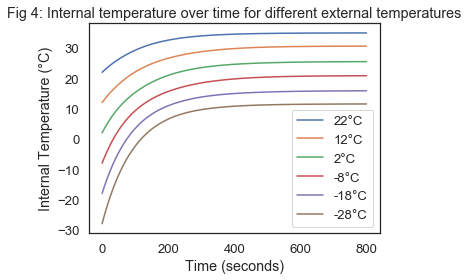

In [449]:
ax = results.plot()
ax = results1.plot(ax=ax)
ax = results2.plot(ax=ax)
ax = results3.plot(ax=ax)
ax = results4.plot(ax=ax)
results5.plot(ax=ax)

decorate(xlabel='Time (seconds)',
         ylabel='Internal Temperature (°C)',
         title='Fig 4: Internal temperature over time for different external temperatures')

As shown in figure 4, the sleeping bag's final internal temperature raises to a comfortable temperature of around 20 degrees celcius when the environmental temperature is -8 degrees celcius (17.6 degrees F). When the environmental temperature of the sleeping bag is less than -8 degrees C, the final temperature of the sleeping bag does not reach 20 degrees C. 

# Interpretation

Figure 3 shows that our model fits our data well. The graph shows the internal temperature of the sleeping bag raising quickly and then eventually leveling off and becoming a near constant temperature. 

As shown in figure 4, the sleeping bag will reach a final temperature of 20 degrees C when in an external environment of -8 degrees C. This is considered a comfortable sleeping temperature because this is approximately room temperature. Since our sleeping bag reaches a minimum comfortable internal temperature when the external temperature is -8 degrees C, we can consider -8 degrees C (17.6 degrees F) to be the minimum environmental temperature our sleeping bag is rated to. Since our sleeping bag is actually rated as a 20 degree F sleeping bag, we believe our model accurately depicts the performance of our sleeping bag. 

One fault in our model is that we did not have an accurate way to measure the mass of the air inside the sleeping bag. We also did not know exactly how much heat was being transferred directly from the test subject into the ground. For simplicity of the model, we assumed that all people produced heat at equal rates regardless of activity level before entering the sleeping bag, size, and weight. In addition, we used Euler's Method to calculate total thermal energy, which is an approximation. 

# Abstract

The goal of our model was to answer the question: How cold can it be outside for me to comfortably sleep in my sleeping bag? Based on our model, we determined that the minimum external temperature required to stay comfortable while sleeping in our sleeping bag is approximately -8 degrees C (17.6 degrees F). 

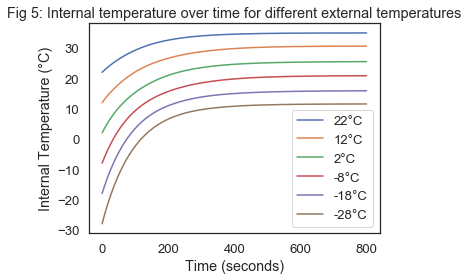

In [408]:
ax = results.plot()
ax = results1.plot(ax=ax)
ax = results2.plot(ax=ax)
ax = results3.plot(ax=ax)
ax = results4.plot(ax=ax)
results5.plot(ax=ax)

decorate(xlabel='Time (seconds)',
         ylabel='Internal Temperature (°C)',
         title='Fig 5: Internal temperature over time for different external temperatures')

Figure 5 demonstrates how the sleeping bag's internal temperature is affected by external temperature. The graph shows that the sleeping bag reaches a minimum comfortable temperature of 20 degrees C when the external temperature is -8 degrees C. 